In [0]:
project_name = 'test_project_1'
#permissions='default'
permissions='fulldata'

In [0]:
%run /Snippets/header_008

PROJECT DETAILS:
Project identifier: test_project_1
Cluster data access level: fulldata


EXECUTION DETAILS:
Spark version: 11.3.x-scala2.12, 
Cluster Node Type: i3.xlarge, 
Driver Node Type: c4.2xlarge, 
Worker Node Type: i3.xlarge


In [0]:
%pip install markupsafe==2.0.1
%pip install rpy2

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  ERROR: Command errored out with exit status 1:
   command: /local_disk0/.ephemeral_nfs/envs/pythonEnv-a72c5df1-a35f-497c-83ed-302bb94aca18/bin/python /local_disk0/.ephemeral_nfs/envs/pythonEnv-a72c5df1-a35f-497c-83ed-302bb94aca18/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py get_requires_for_build_wheel /tmp/tmp42ckadng
       cwd: /tmp/pip-install-s96y8p7r/rpy2_ee368ac41e264716907c67f5977c1f82
  Complete output (16 lines):
  Traceback (most recent call last):
    File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a72c5df1-a35f-497c-83ed-302bb94aca18/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py", line 349, 

DATA SNAPSHOT DETAILS:
This notebook uses the latest snapshot date for this version: "v008.20231003094404/", (03 October 2023)

 The following are the Scopus snapshot dates available for datasets at v008:
['v008.20220314092239/', 'v008.20220906063204/', 'v008.20221021151538/', 'v008.20230509104116/', 'v008.20230821105000/', 'v008.20231003094404/']
(If you want to use a different snapshot, in the first cell of your notebook, set the variable `custom_snapshot_date` to one of the options listed above (string data type))



DATA SAMPLE DETAILS:
Setting paths to run on full datasets (100% Scopus publication volume)


#### merge the media names with us data

In [0]:
import pandas as pd

#load the saved us data
t = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv")

#only extract the data that has media citation
ff = t[t['news_cnt'] > 0]
print("number of unique doi in cited us data ",ff['doi'].nunique())
print("length of total data ",len(ff))

#remove the retracted dois
ret = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/retrected_doi_wos.csv")
retracted = ret.select('doi').toPandas()
ids_to_remove = retracted['doi']
total = ff[~ff['doi'].isin(ids_to_remove)]
print("length of data after removing retracted ids ",len(total))
print("length of unique doi after removing retracted ids ",total['doi'].nunique())
print("total mention ",total['news_cnt'].sum())
total = total.drop_duplicates(subset = ['doi'])
print("len of total after dropping duplicate dois ",len(total))

#merge dois with the media outlet names
m = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/doi_media_for_databricks.csv")
media = m.toPandas()
new_total =total.merge(media, on = ['doi'], how = 'inner') 
print("len of total mention ",len(new_total))
print("len of unique doi in merged data ",new_total['doi'].nunique())
print(new_total['media'].nunique())
#print(new_total.dtypes)

number of unique doi in cited us data  129439
length of total data  129451
length of data after removing retracted ids  129440
length of unique doi after removing retracted ids  129428
total mention  1405538
len of total after dropping duplicate dois  129428
len of total mention  1405448
len of unique doi in merged data  129428
5113


In [0]:
print(new_total['doi'].nunique())
print(len(new_total))
print(new_total.head(5))
a = new_total.drop_duplicates(subset = ['doi','media'])
print(a['doi'].nunique())
print(len(a))
print(a['news_cnt'].min())

129428
1405448
     Domain_English                      Field_English  \
0  Applied Sciences  Agriculture, Fisheries & Forestry   
1  Applied Sciences  Agriculture, Fisheries & Forestry   
2  Applied Sciences  Agriculture, Fisheries & Forestry   
3  Applied Sciences  Agriculture, Fisheries & Forestry   
4  Applied Sciences  Agriculture, Fisheries & Forestry   

         SubField_English        srcid openaccess_status  \
0  agronomy & agriculture  21100941001               YES   
1  agronomy & agriculture  21100941001               YES   
2  agronomy & agriculture  21100941001               YES   
3  agronomy & agriculture  21100941001               YES   
4  agronomy & agriculture  21100941001               YES   

                         doi  news_cnt  year      issn  num_au  ... TopicId  \
0  10.3389/fsufs.2020.577723        21  2020  2571581X       5  ...    3195   
1  10.3389/fsufs.2020.577723        21  2020  2571581X       5  ...    3195   
2  10.3389/fsufs.2020.577723        21

In [0]:
ma = a['doi'].value_counts().reset_index()
ma.columns = ['doi','unique_counts']
print(len(ma))

unique_data = a.merge(ma, on = ['doi'], how = "inner")
print(len(unique_data))

129428
1195149


In [0]:
unique_data = unique_data.drop_duplicates(subset = ['doi'])
print(len(unique_data))
print(unique_data['doi'].nunique())
#print(unique_data.head(10))

129428
129428


In [0]:
unique_data['unique_counts'].min()

Out[11]: 1

#### ​Distribution of cited papers across domains

In [0]:
samp = unique_data.copy(deep = True)
print(len(samp))
for i in samp['Domain_English'].unique():
    a = samp[samp['Domain_English'] == i]
    print(i," ",len(a)/len(samp))

129428
Applied Sciences   0.08821893253391848
Arts & Humanities   0.012331180270111567
Economic & Social Sciences   0.05967796767314646
Health Sciences   0.7032172327471644
Natural Sciences   0.13655468677565905


#### proportion of female in top and bottom 5% cited papers across domains

In [0]:
samp = unique_data.copy(deep = True)
gender = []
for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male")
samp['gender'] = gender


for i in samp['Domain_English'].unique():
    s2 = samp[samp['Domain_English'] == i]
    top = s2['unique_counts'].quantile(0.95)

    top1 = s2[s2['unique_counts'] >= top]
    v1 = len(top1[top1['gender'] == "female"])/len(top1)

    top = s2['unique_counts'].quantile(0.05)
    
    top1 = s2[s2['unique_counts'] <= top]
    v2 = len(top1[top1['gender'] == "female"])/len(top1)
    print(i," top female ",v1," bottom female ",v2)

Applied Sciences  top female  0.29180887372013653  bottom female  0.3120320855614973
Arts & Humanities  top female  0.2345679012345679  bottom female  0.4755877034358047
Economic & Social Sciences  top female  0.3677581863979849  bottom female  0.44308528712198436
Health Sciences  top female  0.3974886339034423  bottom female  0.4162358601627681
Natural Sciences  top female  0.2756339581036384  bottom female  0.28458989229494613


Out[11]: Text(0.5, 0, 'Proporting of female corresponding author in top and bottom 5 % cited papers')

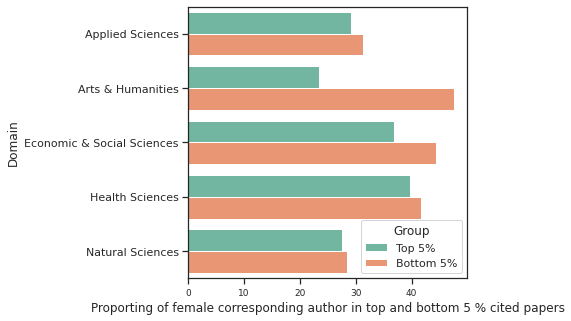

In [0]:
##plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
Domain = ["Applied Sciences","Applied Sciences","Arts & Humanities","Arts & Humanities",
         "Economic & Social Sciences","Economic & Social Sciences","Health Sciences","Health Sciences",
         "Natural Sciences","Natural Sciences"]
Group = ["Top 5%","Bottom 5%","Top 5%","Bottom 5%","Top 5%","Bottom 5%","Top 5%","Bottom 5%",
        "Top 5%","Bottom 5%"]
Percent = [29.18, 31.20, 23.45, 47.56,36.78,44.31, 39.75, 41.62, 27.56, 28.45]
data = pd.DataFrame()
data['Domain'] = Domain
data['Group'] = Group
data['Percent'] = Percent

sns.set_theme(style="ticks", palette="tab10")
fig = plt.figure(figsize =(5, 5))

# Load the example tips dataset


# Draw a nested boxplot to show bills by day and time
sns.barplot(x="Percent", y="Domain",
            hue="Group", palette="Set2",
            data=data)
plt.xticks(fontsize = 9)
plt.xlabel("Proporting of female corresponding author in top and bottom 5 % cited papers")

Out[15]: <AxesSubplot:xlabel='actual', ylabel='Top'>

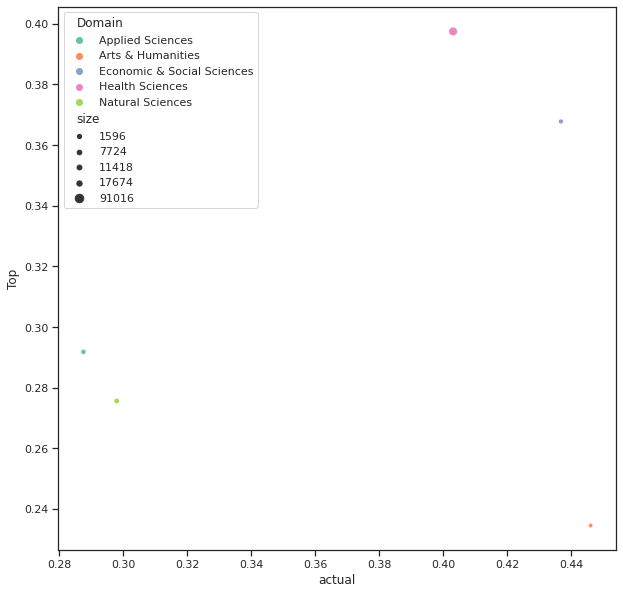

In [0]:
##plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
Domain = ["Applied Sciences","Arts & Humanities",
         "Economic & Social Sciences","Health Sciences",
         "Natural Sciences"]

Percent_top = [29.18/100, 23.45/100,36.78/100, 39.75/100, 27.56/100]
Percent_bot = [31.20/100,  47.56/100,44.31/100,  41.62/100, 28.45/100]
size = [11418, 1596, 7724, 91016, 17674]
val = [28.76/100, 44.61/100, 43.68/100, 40.31/100, 29.8/100]
data = pd.DataFrame()
data['Domain'] = Domain
data['Top'] = Percent_top
data['Bottom'] = Percent_bot
data['actual'] = val
data['size'] = size

sns.set_theme(style="ticks", palette="tab10")
fig = plt.figure(figsize =(10, 10))

# Load the example tips dataset


# Draw a nested boxplot to show bills by day and time
sns.scatterplot(x="actual", y="Top",
            hue="Domain", palette="Set2",
            data=data, size = "size")
#plt.xticks(fontsize = 9)
#plt.xlabel("Proporting of female corresponding author in top and bottom 5 % cited papers")

### proportion of female in top and bottom 5% cited papers across fields for fig 5

In [0]:
samp = unique_data.copy(deep = True)
gender = []
for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append("female")
  elif samp['cor_gender'][ind] == 'male' or samp['cor_gender'][ind] == 'm' or samp['cor_gender'][ind] == 'M':
    gender.append("male")
samp['gender'] = gender

fld, t, b = [],[],[]
dom = []
for i in samp['Field_English'].unique():
    s2 = samp[samp['Field_English'] == i]
    top = s2['unique_counts'].quantile(0.95)

    top1 = s2[s2['unique_counts'] >= top]
    v1 = len(top1[top1['gender'] == "female"])/len(top1)

    top = s2['unique_counts'].quantile(0.05)
    
    top1 = s2[s2['unique_counts'] <= top]
    v2 = len(top1[top1['gender'] == "female"])/len(top1)
    #print(i," top female ",v1," bottom female ",v2)
    fld.append(i)
    t.append(v1)
    b.append(v2)
    dom.append(top1.iloc[0]['Domain_English'])
print(fld)
print(t)    
print(b)
print(dom)

['Agriculture, Fisheries & Forestry', 'Built Environment & Design', 'Enabling & Strategic Technologies', 'Engineering', 'Information & Communication Technologies', 'Communication & Textual Studies', 'Historical Studies', 'Philosophy & Theology', 'Visual & Performing Arts', 'Economics & Business ', 'Social Sciences', 'Biomedical Research', 'Clinical Medicine', 'Psychology & Cognitive Sciences', 'Public Health & Health Services', 'Biology', 'Chemistry', 'Earth & Environmental Sciences', 'Mathematics & Statistics', 'Physics & Astronomy']
[0.4642857142857143, 0.21052631578947367, 0.25263157894736843, 0.25263157894736843, 0.2289156626506024, 0.25, 0.27586206896551724, 0.45454545454545453, 0.5, 0.27972027972027974, 0.41732283464566927, 0.342534504391468, 0.37703826955074876, 0.5278688524590164, 0.5143338954468802, 0.31645569620253167, 0.19727891156462585, 0.2242152466367713, 0.36363636363636365, 0.1951219512195122]
[0.4494535519125683, 0.37404580152671757, 0.24460874922982132, 0.277087033747

#### avg citation received by male vs female corresponding authors

In [0]:
samp = unique_data.copy(deep = True)
gender = []
for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male")
samp['gender'] = gender

for i in samp['Domain_English'].unique():
    s = samp[samp['Domain_English'] == i]
    f = s[s['gender'] == "female"]
    m = s[s['gender'] == "male"]

    # Group by 'id' and calculate the sum of 'value' for each group
    f_grp = f.groupby('cor_au1')['unique_counts'].sum().reset_index()

    m_grp = m.groupby('cor_au1')['unique_counts'].sum().reset_index()

    print(i," female ",f_grp['unique_counts'].mean()," male ",m_grp['unique_counts'].mean())

Applied Sciences  female  10.778207109737249  male  12.943498978897209
Arts & Humanities  female  9.983579638752053  male  14.117403314917127
Economic & Social Sciences  female  8.21445866482186  male  9.952207937395192
Health Sciences  female  12.803482892849825  male  14.989757479530525
Natural Sciences  female  14.868325682532012  male  17.445607150643124


Applied Sciences  female  8.076805354721035  male  8.774230318796977
Arts & Humanities  female  8.06759715380405  male  10.47010435850215
Economic & Social Sciences  female  6.907050616856912  male  7.743931832095611
Health Sciences  female  7.73823351277618  male  8.003563965711072
Natural Sciences  female  11.271343338817367  male  12.456987986942204
Out[28]: "# Expand xticks into multiline\nlabels = [label.replace(' ', '\n') for label in dtplt['Domain']]\nplt.xticks(range(len(dtplt['Domain'])), labels)"

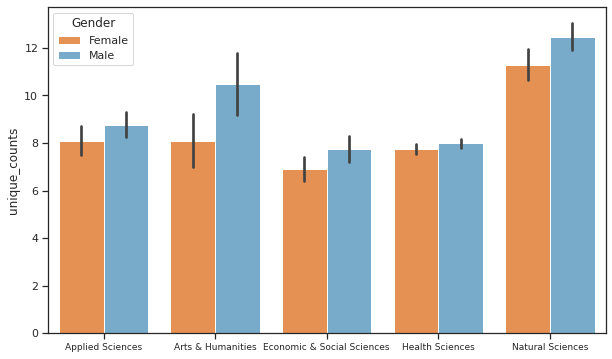

In [0]:
##plotting
samp = unique_data.copy(deep = True)
gender = []
for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append("female")
  elif samp['cor_gender'][ind] == 'male' or samp['cor_gender'][ind] == 'm' or samp['cor_gender'][ind] == 'M':
    gender.append("male")
samp['gender'] = gender

dtplt = pd.DataFrame()
for i in samp['Domain_English'].unique():
    s = samp[samp['Domain_English'] == i]
    f = s[s['gender'] == "female"]
    m = s[s['gender'] == "male"]

    # Group by 'id' and calculate the sum of 'value' for each group
    f_grp = f.groupby('cor_au1')['unique_counts'].mean().reset_index()
    f_grp['Gender'] = "Female"
    f_grp['Domain'] = i

    m_grp = m.groupby('cor_au1')['unique_counts'].mean().reset_index()
    m_grp['Gender'] = "Male"
    m_grp['Domain'] = i
    dtplt = pd.concat([dtplt,f_grp])
    dtplt = pd.concat([dtplt,m_grp])

    print(i," female ",f_grp['unique_counts'].mean()," male ",m_grp['unique_counts'].mean())
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme(style="ticks", palette="Set1")
fig = plt.figure(figsize =(10, 6))
a = sns.color_palette(palette='tab20c')
a = a.as_hex()
c = {'Male':a[1],'Female':a[5]}
# Load the example tips dataset
#print(dtplt['Domain'].unique())
'''newdom = []
for ind in dtplt.index:
  #print("yess")
#  print(dtplt['Domain'][ind])
  if str(dtplt['Domain'][ind]) == "Applied Sciences":
    newdom.append("Applied\nSciences")
  elif str(dtplt['Domain'][ind]) == "Arts & Humanities":
    newdom.append("Arts\n&\nHumanities")
  elif str(dtplt['Domain'][ind]) == "Economic & Social Sciences":
    newdom.append("Econ. & Social\nSciences")
  elif str(dtplt['Domain'][ind]) == "Health Sciences":
    newdom.append("Health\nSciences")
  elif str(dtplt['Domain'][ind]) == "Natural Sciences":
    newdom.append("Natural\nSciences")
  else:
    print(dtplt['Domain'][ind])


dtplt['newdom'] = newdom'''
#print(dtplt.head(5))
# Draw a nested boxplot to show bills by day and time
ax = sns.barplot(y="unique_counts", x="Domain",
            hue="Gender", palette=c,
            data=dtplt, estimator = np.mean)
plt.xticks(fontsize = 9)
ax.set(xlabel=None)
#plt.xticks([0, 1, 2, 3], ['Group1', 'Group2', 'Group3', 'Group4'], rotation=0, fontsize=9)


'''# Expand xticks into multiline
labels = [label.replace(' ', '\n') for label in dtplt['Domain']]
plt.xticks(range(len(dtplt['Domain'])), labels)'''

<command-1876368214012405>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  a['newdom'] = a['Domain'].str.replace(r'\s', '\n')
Out[30]: Text(0, 0.5, 'Avg # of media citation')

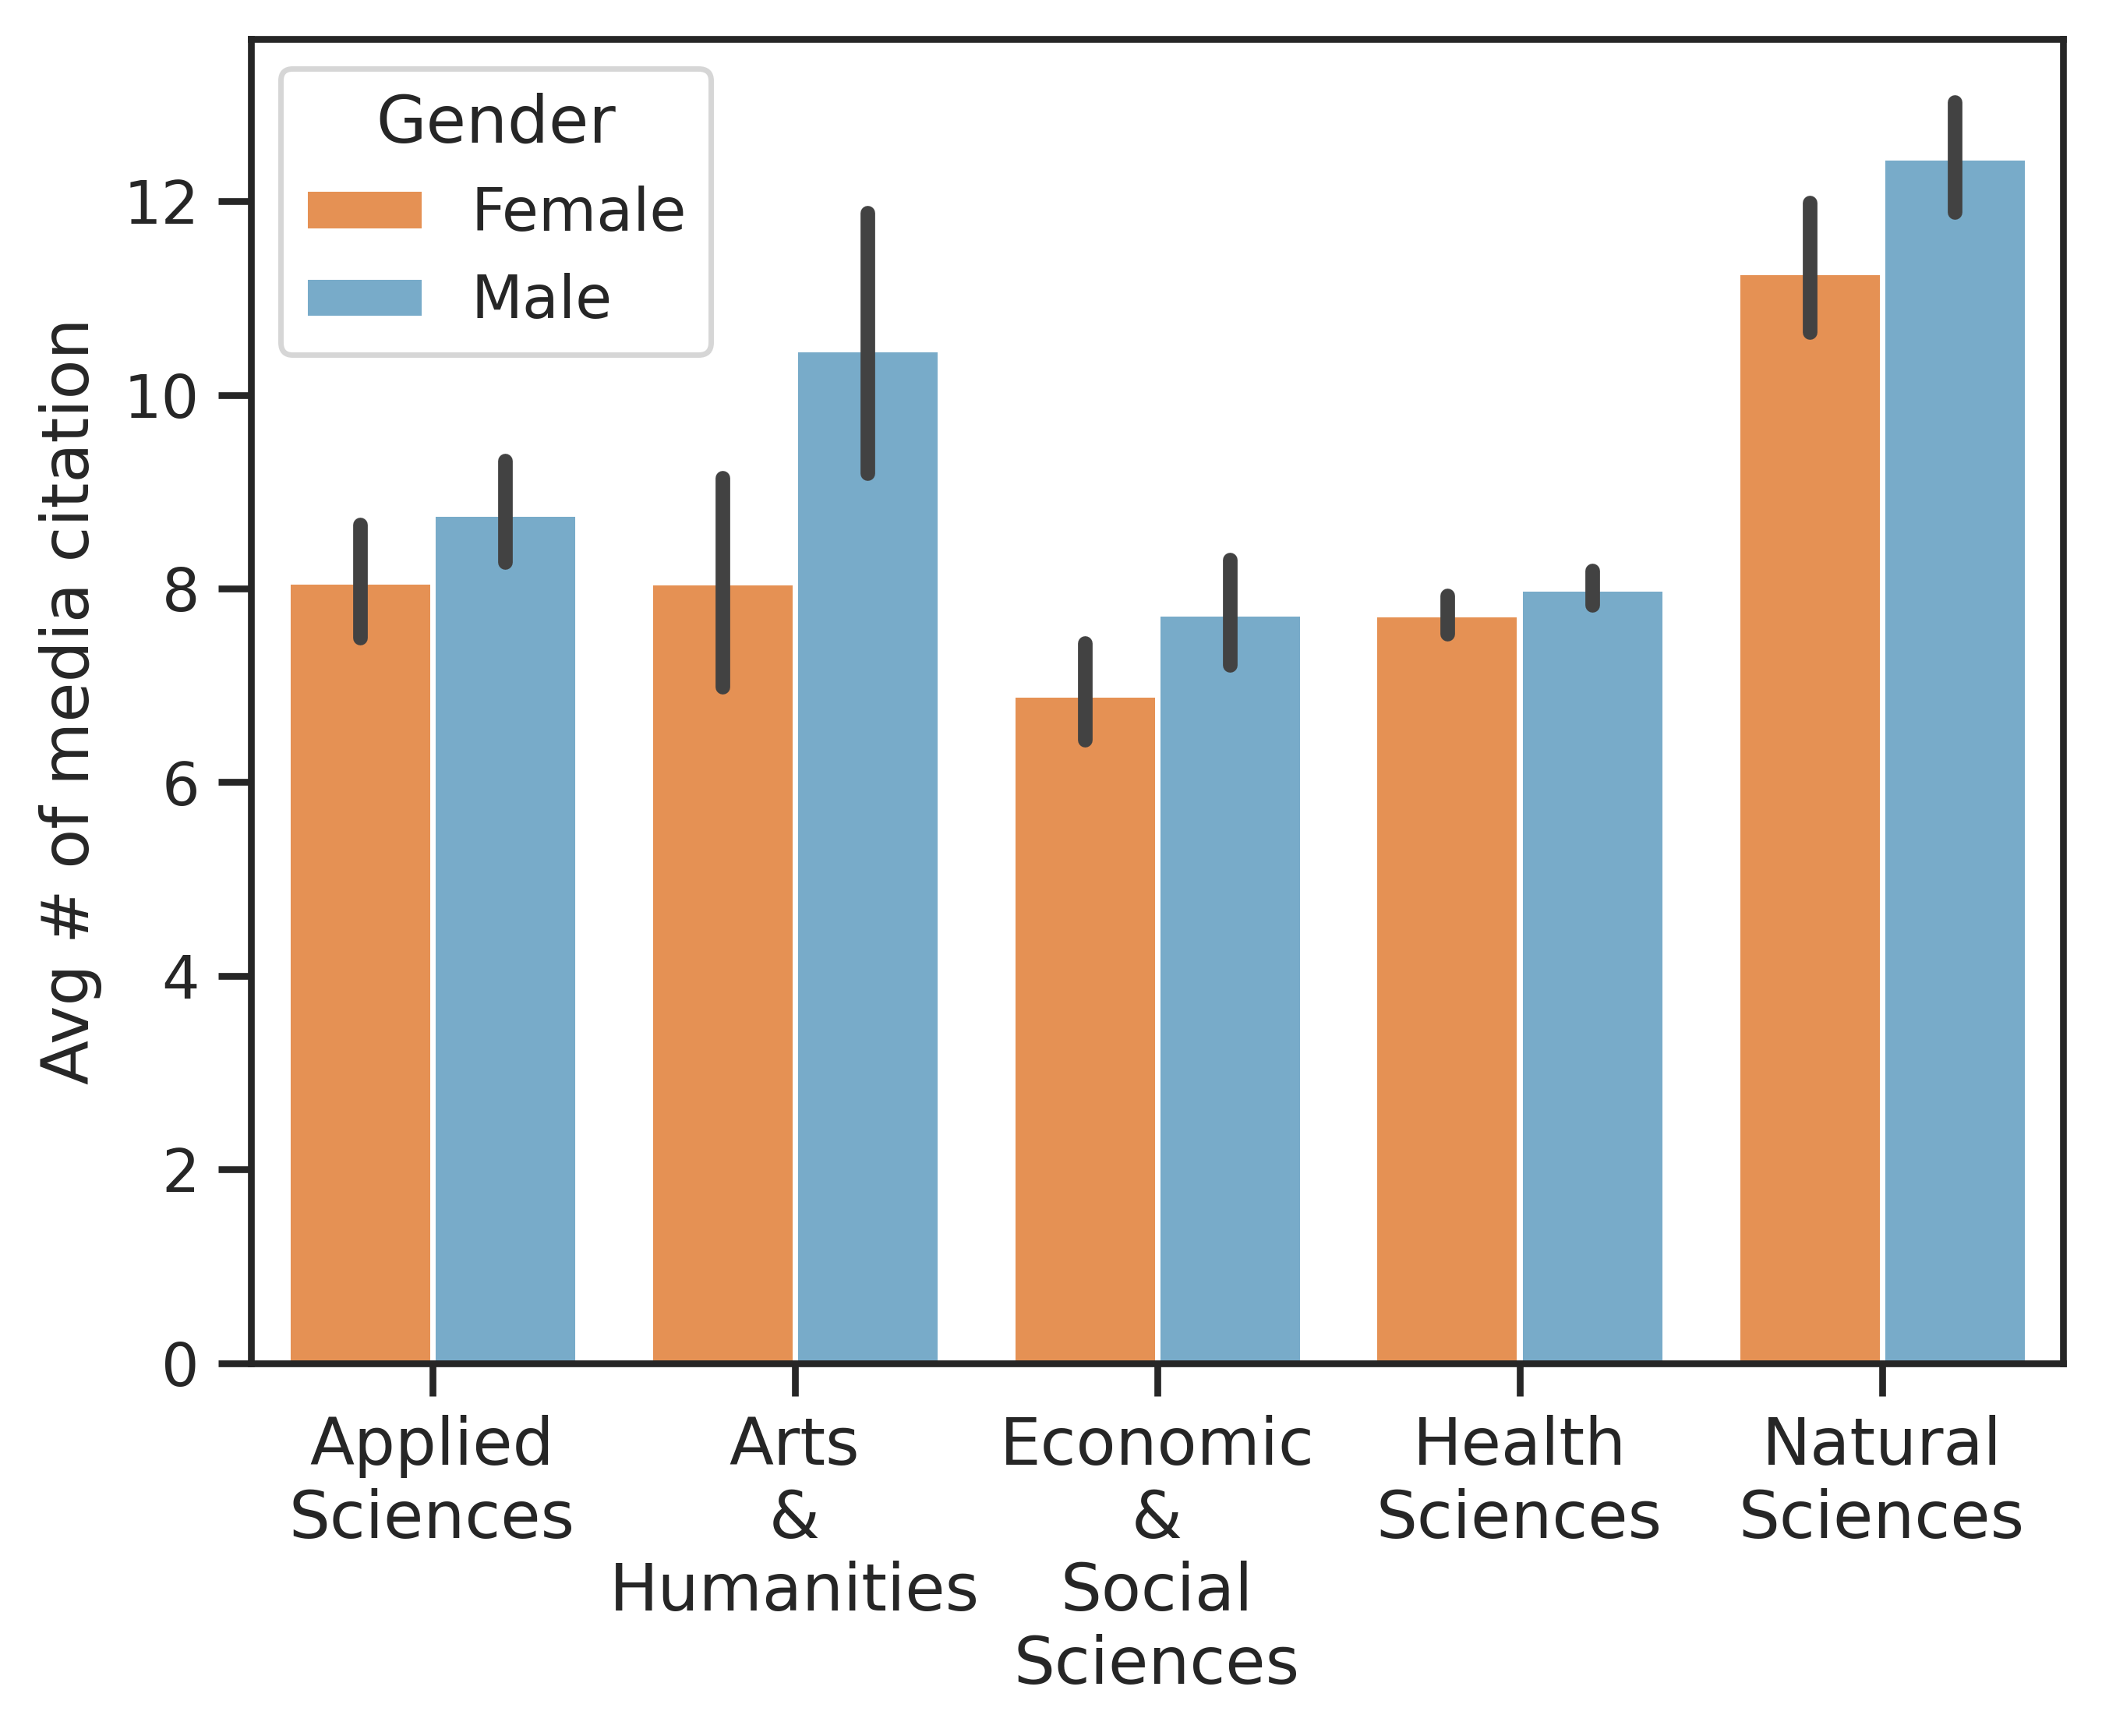

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette="Set1")
fig = plt.figure(figsize =(6, 4.5), dpi = 500)
aa = sns.color_palette(palette='tab20c')
aa = aa.as_hex()
c = {'Male':aa[1],'Female':aa[5]}

a = dtplt.copy(deep = True)
a['newdom'] = a['Domain'].str.replace(r'\s', '\n')

ax = sns.barplot(y="unique_counts", x="newdom",
            hue="Gender", palette=c,
            data=a, estimator = np.mean)
plt.xticks(fontsize = 12)
ax.set(xlabel=None)
plt.ylabel("Avg # of media citation", fontsize = 12)

#### avg citation received by top 5% highly cited male vs top 5% highly cited female authors

In [0]:
samp = unique_data.copy(deep = True)
gender = []
for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male")
samp['gender'] = gender

for i in samp['Domain_English'].unique():
    s = samp[samp['Domain_English'] == i]
    f = s[s['gender'] == "female"]
    m = s[s['gender'] == "male"]

    # Group by 'id' and calculate the sum of 'value' for each group
    f_grp = f.groupby('cor_au1')['unique_counts'].sum().reset_index()
    threshold = f_grp['unique_counts'].quantile(0.95)
    f_grp = f_grp[f_grp['unique_counts'] >= threshold]
    #print(f_grp['unique_counts'].mean())

    m_grp = m.groupby('cor_au1')['unique_counts'].sum().reset_index()
    threshold = m_grp['unique_counts'].quantile(0.95)
    m_grp = m_grp[m_grp['unique_counts'] >= threshold]
    print(i," female ",f_grp['unique_counts'].mean()," male ",m_grp['unique_counts'].mean())

Applied Sciences  female  86.78030303030303  male  106.37417218543047
Arts & Humanities  female  67.35483870967742  male  112.35135135135135
Economic & Social Sciences  female  56.65068493150685  male  80.10382513661202
Health Sciences  female  112.5572457966373  male  133.7892156862745
Natural Sciences  female  118.62857142857143  male  151.74298056155507


31.0
27.0
27.0
32.0
43.0
Out[33]: (0.0, 300.0)

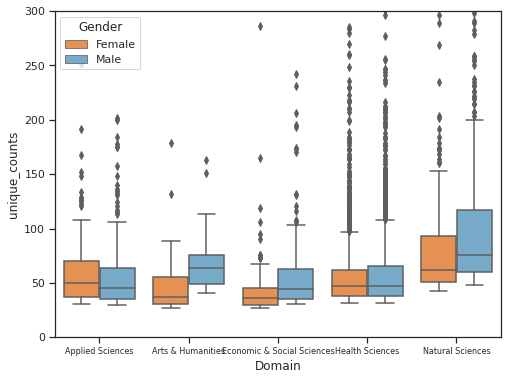

In [0]:
#plotting
samp = unique_data.copy(deep = True)
gender = []
for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male")
samp['gender'] = gender

dtplt = pd.DataFrame()
for i in samp['Domain_English'].unique():
    s = samp[samp['Domain_English'] == i]
    f = s[s['gender'] == "female"]
    m = s[s['gender'] == "male"]
    #print(f['cor_au1'].nunique())

    # Group by 'id' and calculate the sum of 'value' for each group
    f_grp = f.groupby('cor_au1')['unique_counts'].mean().reset_index()
    #print(f_grp.head(3))
    #print(len(f_grp))
    threshold = f_grp['unique_counts'].quantile(0.95)
    f_grp = f_grp[f_grp['unique_counts'] >= threshold]
    f_grp['Gender'] = "Female"
    f_grp['Domain'] = i
    
    #print(f_grp['unique_counts'].mean())
    print(threshold)

    m_grp = m.groupby('cor_au1')['unique_counts'].mean().reset_index()
    threshold = m_grp['unique_counts'].quantile(0.95)
    m_grp = m_grp[m_grp['unique_counts'] >= threshold]
    m_grp['Gender'] = "Male"
    m_grp['Domain'] = i
    dtplt = pd.concat([dtplt,f_grp])
    dtplt = pd.concat([dtplt,m_grp])
    #print(i," female ",f_grp['unique_counts'].median()," male ",m_grp['unique_counts'].median())

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette="Set1")
fig = plt.figure(figsize =(8, 6))

a = sns.color_palette(palette='tab20c')
a = a.as_hex()
c = {'Male':a[1],'Female':a[5]}

# Load the example tips dataset


# Draw a nested boxplot to show bills by day and time
sns.boxplot(y="unique_counts", x="Domain",
            hue="Gender", palette=c,
            data=dtplt)
plt.xticks(fontsize = 8)
plt.ylim([0,300])
#sns.despine(offset=10, trim=True)

<command-1876368214012406>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  a['newdom'] = a['Domain'].str.replace(r'\s', '\n')
Out[34]: Text(0, 0.5, 'Avg # of media citation')

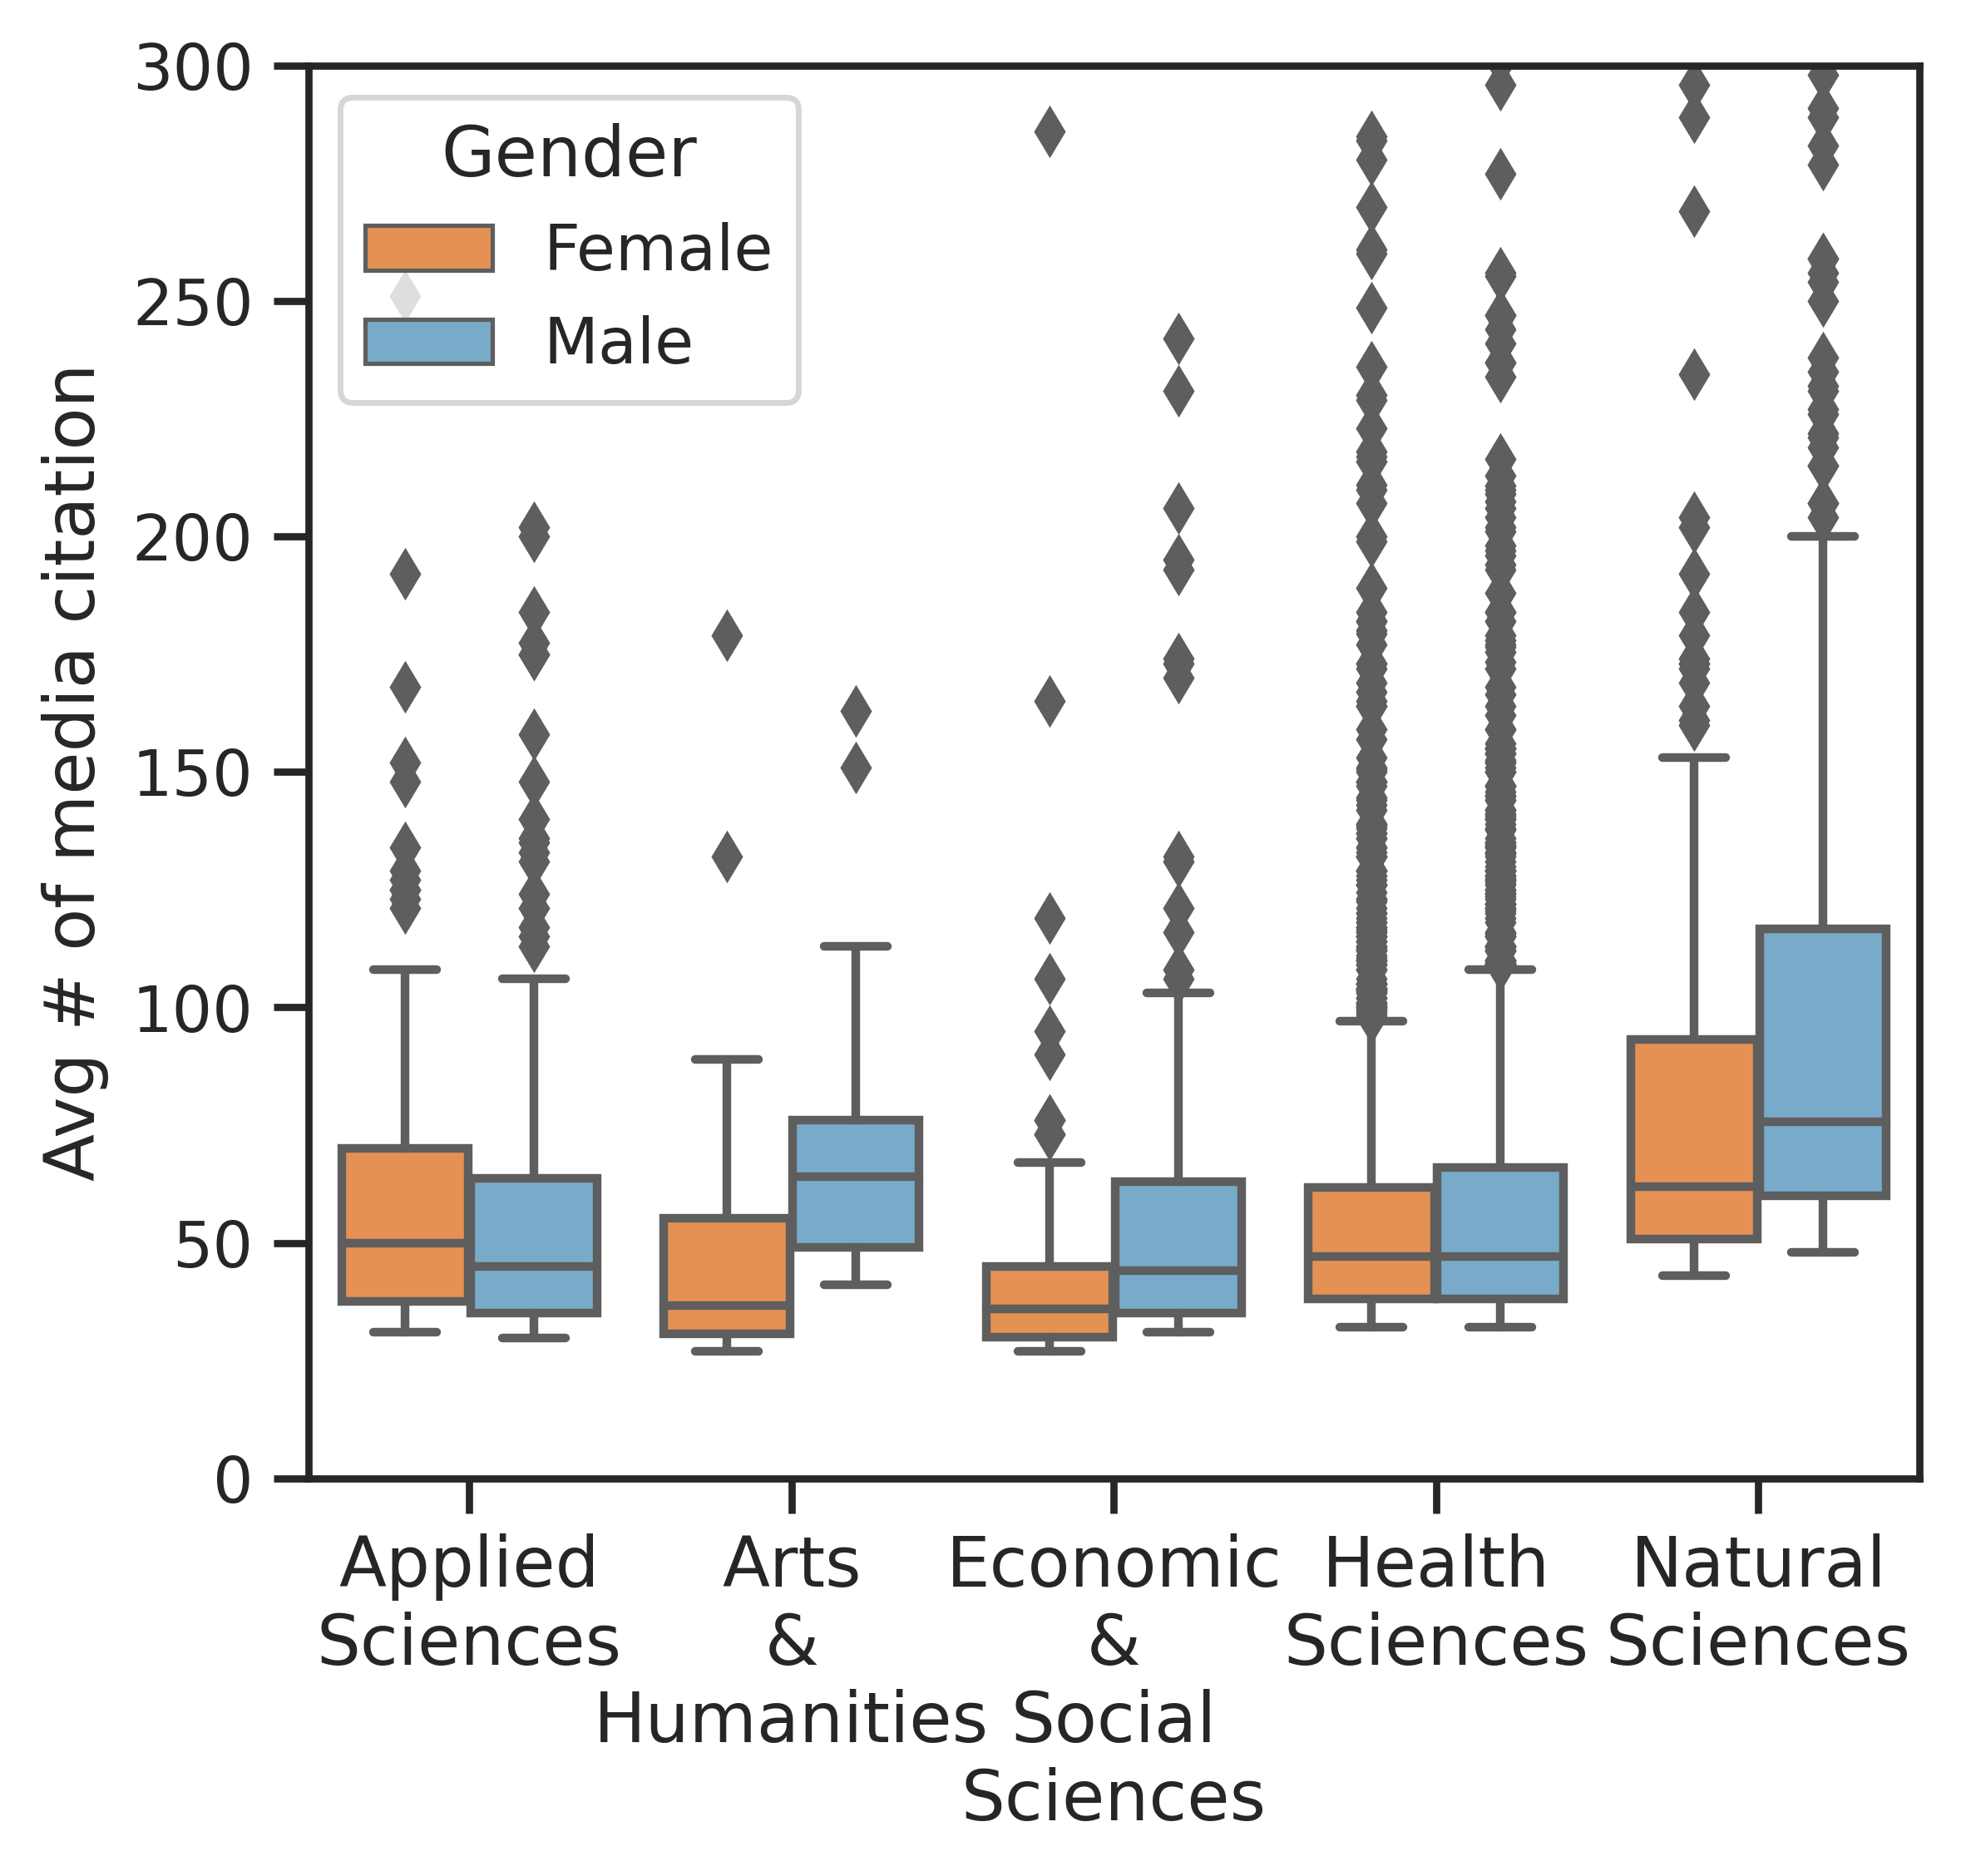

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette="Set1")
fig = plt.figure(figsize =(5, 4.5), dpi = 500)
aa = sns.color_palette(palette='tab20c')
aa = aa.as_hex()
c = {'Male':aa[1],'Female':aa[5]}

a = dtplt.copy(deep = True)
a['newdom'] = a['Domain'].str.replace(r'\s', '\n')


ax = sns.boxplot(y="unique_counts", x="newdom",
            hue="Gender", palette=c,
            data=a)
#plt.xticks(fontsize = 8)
plt.ylim([0,300])

'''ax = sns.barplot(y="unique_counts", x="newdom",
            hue="Gender", palette=c,
            data=a)'''
plt.xticks(fontsize = 12)
ax.set(xlabel=None)
plt.ylabel("Avg # of media citation", fontsize = 12)

#### proportion of female in top 5%highly cited authors across domains

In [0]:
samp = unique_data.copy(deep = True)
gender = []

for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append("female")
  elif samp['cor_gender'][ind] == 'male' or samp['cor_gender'][ind] == 'm' or samp['cor_gender'][ind] == 'M':
    gender.append("male")

samp['gender'] = gender

ss = pd.DataFrame()
ss['cor_au1'] = samp['cor_au1']
ss['gender'] = samp['gender']
ss= ss.drop_duplicates()

for i in samp['Domain_English'].unique():
    x = samp[samp['Domain_English'] == i]
    grp = x.groupby('cor_au1')['unique_counts'].mean().reset_index()
    threshold = grp['unique_counts'].quantile(0.95)
    grp = grp[grp['unique_counts'] >= threshold]
    #print(len(grp))
    g2 = grp.merge(ss, on = "cor_au1", how = "inner")
    #print(len(g2))
    print(i," ",len(g2[g2['gender'] == "female"])/len(g2))

Applied Sciences   0.3186046511627907
Arts & Humanities   0.29850746268656714
Economic & Social Sciences   0.4024024024024024
Health Sciences   0.4393305439330544
Natural Sciences   0.2786885245901639


#### proportion of female in bottom 5% highly cited authors across domains

In [0]:
samp = unique_data.copy(deep = True)
gender = []

for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male")

samp['gender'] = gender

ss = pd.DataFrame()
ss['cor_au1'] = samp['cor_au1']
ss['gender'] = samp['gender']
ss= ss.drop_duplicates()

for i in samp['Domain_English'].unique():
    x = samp[samp['Domain_English'] == i]
    grp = x.groupby('cor_au1')['unique_counts'].mean().reset_index()
    threshold = grp['unique_counts'].quantile(0.05)
    print(threshold)
    grp = grp[grp['unique_counts'] <= threshold]
    #print(len(grp))
    g2 = grp.merge(ss, on = "cor_au1", how = "inner")
    #print(len(g2))
    print(i," ",len(g2[g2['gender'] == "female"])/len(g2))

1.0
Applied Sciences   0.33296047725577926
1.0
Arts & Humanities   0.4820627802690583
1.0
Economic & Social Sciences   0.45458368376787217
1.0
Health Sciences   0.4548955916473318
1.0
Natural Sciences   0.30372840254622613


Out[42]: <matplotlib.legend.Legend at 0x7f2c7a97d400>

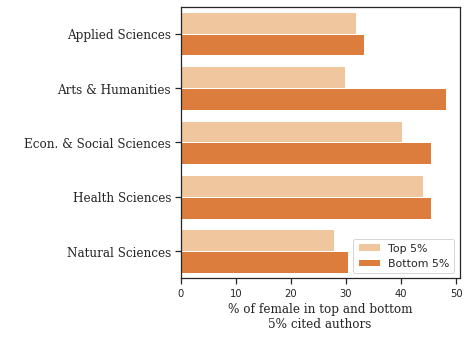

In [0]:
##plotting
##plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
Domain = ["Applied Sciences","Applied Sciences","Arts & Humanities","Arts & Humanities",
         "Econ. & Social Sciences","Econ. & Social Sciences","Health Sciences","Health Sciences",
         "Natural Sciences","Natural Sciences"]
Group = ["Top 5%","Bottom 5%","Top 5%","Bottom 5%","Top 5%","Bottom 5%","Top 5%","Bottom 5%",
        "Top 5%","Bottom 5%"]
#Percent = [29.28, 33.74, 25.72, 48.51,  37.06,45.40,   37.45, 46.34,   25.59, 30.79]
Percent = [31.86,33.29,29.85,48.20,40.24,45.45, 43.93,45.48,27.86,30.37]
data = pd.DataFrame()
data['Domain'] = Domain
data['Group'] = Group
data['Percent'] = Percent 

sns.set_theme(style="ticks", palette="tab10")
fig = plt.figure(figsize =(5, 5))

# Load the example tips dataset
c = ['#fdc692', '#f67824']

# Draw a nested boxplot to show bills by day and time
sns.barplot(x="Percent", y="Domain",
            hue="Group", palette=c,
            data=data)
plt.yticks(fontsize = 12,fontweight = "normal", fontfamily = "serif")
plt.xticks(fontsize = 10)
plt.xlabel("% of female in top and bottom\n5% cited authors", fontweight = "normal", fontfamily = "serif")
plt.ylabel(" ")
plt.legend(loc = "lower right")

In [0]:
a = sns.color_palette(palette='Oranges')
print(a.as_hex())

print(len(unique_data))
print(unique_data['doi'].nunique())

['#fee3c8', '#fdc692', '#fda057', '#f67824', '#e05206', '#ad3803']
129428
129428


#### raw count regression analysis

In [0]:
import numpy as np
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
#utils = rpackages.importr('utils')
#utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')
mass = importr("MASS")

In [0]:
'''utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('gtsummary')
gtsummary = importr("gtsummary")'''


R[write to console]: Installing package into ‘/databricks/spark/R/lib’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘V8’, ‘xfun’, ‘reactR’, ‘labelled’, ‘cli’, ‘lifecycle’, ‘pillar’, ‘rlang’, ‘tidyselect’, ‘bigD’, ‘bitops’, ‘commonmark’, ‘fs’, ‘htmltools’, ‘htmlwidgets’, ‘juicyjuice’, ‘markdown’, ‘reactable’, ‘sass’, ‘broom.helpers’, ‘dplyr’, ‘forcats’, ‘gt’, ‘purrr’, ‘tibble’, ‘vctrs’


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/V8_4.4.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 672334 bytes (656 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

In [0]:
samp = unique_data.copy(deep = True)

gender = []
for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    #gender.append('0')
    gender.append("female")
    
  else:
    #gender.append('1')
    gender.append("male")
samp['gender'] = gender



coarse_team = []
for ind in samp.index:
  if samp['num_au'][ind] == 1:
      coarse_team.append('1')
  elif samp['num_au'][ind] == 2:
    coarse_team.append('2')
  elif samp['num_au'][ind] == 3:
    coarse_team.append('3')
  elif samp['num_au'][ind] >= 4 and samp['num_au'][ind] <= 5:
    coarse_team.append('4')
  elif samp['num_au'][ind] >= 6 and samp['num_au'][ind] <= 9:
    coarse_team.append('5')
  elif samp['num_au'][ind] > 9:
    coarse_team.append('6')

samp['team_size'] = coarse_team


q1, q2, q3 = 0.124, 0.25, 0.597

q = []
for ind in samp.index:
  if samp['SJR'][ind] <= q1:
    q.append(0)
  elif samp['SJR'][ind] > q1 and samp['SJR'][ind] <= q2:
    q.append(1)
  elif samp['SJR'][ind] > q2 and samp['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
samp['q'] = q

In [0]:
import numpy as np
np.exp(-0.156602773)

Out[47]: 0.8550436377873596

In [0]:
def domain_src(i,nn):
  new = nn.copy(deep = True)
  cov = []
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #mm,ff = [],[]

  a = new[new['Field_English'] == i]

  f = a[a['gender'] == "female"]
  m = a[a['gender'] == "male"]
  print("male ",m['unique_counts'].mean()," female ",f['unique_counts'].mean())


  for ind in a.index:
    if a['year'][ind] == 2018 or a['year'][ind] == 2019:
      cov.append(0)
    else:
      cov.append(1)
  #a['covid'] = cov
  a.loc[:,"covid"] = cov


  #a = a.drop(['srcid'], axis=1)
  a['srcid'] = a['srcid'].astype(str)
  a['cor_au1'] = a['cor_au1'].astype(str)

  return a


#tmp = domain_src("Physics & Astronomy",samp.copy(deep = True)) #est=  0.1878671056, p val = 2.049421e-58 ***
#tmp = domain_src("Mathematics & Statistics",samp.copy(deep = True)) # gender -0.36672087, p val = 1.192890e-01
#tmp = domain_src("Earth & Environmental Sciences",samp.copy(deep = True))# gender  est = 0.1727280303 , p val = 5.00786579e-101 *** 
#tmp = domain_src("Chemistry",samp.copy(deep = True))  #gender  est = 0.075560029, p val = 5.45511892e-04 ***

#tmp = domain_src("Biology",samp.copy(deep = True))  #gender   est = 0.066329239, p val = 5.489133227520739e-16 ***
#tmp = domain_src("Public Health & Health Services",samp.copy(deep = True))  # gender est = 1.167129e-01, err = 0.006872478, p val = 1.10373607e-64 ***

#tmp = domain_src("Psychology & Cognitive Sciences",samp.copy(deep = True))   #gender est -0.022366737, p value = 1.53335948e-02 *

#tmp = domain_src("Clinical Medicine",samp.copy(deep = True)) #it has problem, so removed srcid, gendermale est = 0.05228468, p val = 1.026389e-64

#tmp = domain_src("Biomedical Research",samp.copy(deep = True))  #gender est = 0.016064004 , p val = 4.64875817e-03 **
#tmp = domain_src("Social Sciences",samp.copy(deep = True)) #gender est = 0.0799709439, p val = 6.41768693e-11 ***
#tmp = domain_src("Economics & Business ",samp.copy(deep = True)) #gender est = 0.131894697, p value = 2.53909251e-13 *** 
#tmp = domain_src("Visual & Performing Arts",samp) ##too small sample size #-0.6938

#tmp = domain_src("Philosophy & Theology",samp.copy(deep = True)) #est = 0.006869409, p val = 9.390267e-01 
#tmp = domain_src("Historical Studies",samp.copy(deep = True)) #est = 0.056608583 ,pval= 4.153950e-02 *
#tmp = domain_src("Communication & Textual Studies",samp.copy(deep = True))  #est = 0.23582790 err = 0.03205681, p val =  1.887072e-13 ***
#tmp = domain_src("Information & Communication Technologies",samp.copy(deep = True))  #gender est = 0.23921630, err = 0.0256, p val =  1.21978311e-20 ***

#tmp = domain_src("Engineering",samp.copy(deep = True))  #est = 0.13303623, p val = 4.87299612e-12 ***
#tmp = domain_src("Enabling & Strategic Technologies",samp.copy(deep = True)) #gender est = 0.017029,err= 0.0116, p val = 1.43182135e-01
#tmp = domain_src("Built Environment & Design",samp.copy(deep = True)) #gender est = 0.12887945,err=0.0544, p val = 1.799847e-02 *
tmp = domain_src("Agriculture, Fisheries & Forestry",samp.copy(deep = True)) #gender est = -0.156602773 err = 0.0171747, p val = 7.63640556e-20 ***

#print(tmp.tail(10))


with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('covid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('covid'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('srcid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('srcid'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2'''

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("unique_counts ~ gender+year+subfield_article+team_size+srcid", #
                  data=tst_df,family=ro.r('poisson(link="log")')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')


print(base.summary(model).rx2("coefficients")) #run this for r output


coeffs = base.summary(model).rx2('coefficients')
#print(np.array(coeffs)) #run this if the size is too much

#print(np.array(coeffs)[1])


#print(coeffs)



#p_values = model.rx('summary').rx('coefficients')[0, 4] #base.summary(model).rx2('coefficients')[0, 4]
#print(p_values)
'''
print(coeffs[0])
print(coeffs[1])
print(coeffs[2])
print(coeffs[3])'''

#array = pandas2ri.ri2py(base.summary(model))
#array = ro.conversion.py2rpy(base.summary(model))

#print(coeffs.names[1][1])
#print(array[0])
#print(array.rx2("coefficients"))
#pandas2ri.deactivate()


male  8.12313725490196  female  9.074866310160427
<command-3618160136779160>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['srcid'] = a['srcid'].astype(str)
<command-3618160136779160>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['cor_au1'] = a['cor_au1'].astype(str)
                                           Estimate Std. Error       z value
(Intercept)                            -0.024548984 0.22287665 -0.1101460549
gendermale                             -0.156602773 0.01717470 -9.1182259768
y

In [0]:
print(np.array(coeffs))

[[-2.45489836e-02  2.22876649e-01 -1.10146055e-01  9.12293544e-01]
 [-1.56602773e-01  1.71746975e-02 -9.11822598e+00  7.63640556e-20]
 [-1.23799908e-01  2.61368449e-02 -4.73660492e+00  2.17328255e-06]
 ...
 [ 2.34960893e-01  6.16158231e-01  3.81332068e-01  7.02956861e-01]
 [-3.63186294e-01  1.02371848e+00 -3.54771649e-01  7.22760669e-01]
 [ 1.54057356e+00  4.37942410e-01  3.51775376e+00  4.35216002e-04]]


In [0]:
import scipy.stats 
scipy.stats.norm.sf(abs((6.86940946e-03)/(8.98041409e-02)))*2 ##estimate/etd error
#scipy.stats.norm.sf(abs((-0.156602773)/(0.01717470)))*2

Out[40]: 0.9390266940696844

In [0]:
#mass.confint_glm(model)
#base.summary(model).rx2('confint')
scipy.stats.norm.ppf(0.975)

Out[50]: 1.959963984540054

### Plot confidence interval and rate ratio

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt 
a = pd.DataFrame()
a = pd.DataFrame()
a['field'] = ["Physics & Astronomy","Mathematics & Statistics","Earth & Environmental Sciences","Chemistry","Biology","Public Health & Health Services","Psychology & Cognitive Sciences",
          "Clinical Medicine","Biomedical Research","Social Sciences","Economics & Business","Philosophy & Theology","Historical Studies","Communication & Textual Studies",
          "Information & Communication Technologies","Engineering","Enabling & Strategic Technologies","Built Environment & Design","Agriculture, Fisheries & Forestry"]

a['est'] = [0.1878,-0.3667,0.1727,  0.0755,0.0663,1.167129e-01,-0.0223,0.0522,0.016,0.0799,0.13189,0.00686,0.05660,0.2358,0.2392,0.1330,0.01702,0.12887,-0.1566]

a['error'] = [0.01165,0.2354,0.0080, 0.0218,0.0081,0.006872478, 9.22566928e-03,0.00307,0.0056,1.22398181e-02,0.0180,0.0898,0.0277,0.03205,0.0256,0.0192,0.0116,0.0544,0.0171] 

a['pval'] = ["***"," ","***","***","***","***","*","***","**","***","***"," ","*","***","***","***"," ","*","***"]
a['gender'] = a['est'].apply(lambda x: 1 if x > 0 else 0)
#print(a)

a['odds_ratio'] = a['est'].apply(lambda x: math.exp(x))

left_ci = []
right_ci = []

for ind in a.index:
    left_ci.append(math.exp(a['est'][ind] - 1.96 * a['error'][ind]))
    right_ci.append(math.exp(a['est'][ind] + 1.96 * a['error'][ind]))

a['left_ci'] = left_ci
a['right_ci'] = right_ci
print(a)

                                       field       est     error pval  gender  \
0                        Physics & Astronomy  0.187800  0.011650  ***       1   
1                   Mathematics & Statistics -0.366700  0.235400            0   
2             Earth & Environmental Sciences  0.172700  0.008000  ***       1   
3                                  Chemistry  0.075500  0.021800  ***       1   
4                                    Biology  0.066300  0.008100  ***       1   
5            Public Health & Health Services  0.116713  0.006872  ***       1   
6            Psychology & Cognitive Sciences -0.022300  0.009226    *       0   
7                          Clinical Medicine  0.052200  0.003070  ***       1   
8                        Biomedical Research  0.016000  0.005600   **       1   
9                            Social Sciences  0.079900  0.012240  ***       1   
10                      Economics & Business  0.131890  0.018000  ***       1   
11                     Philo

No handles with labels found to put in legend.


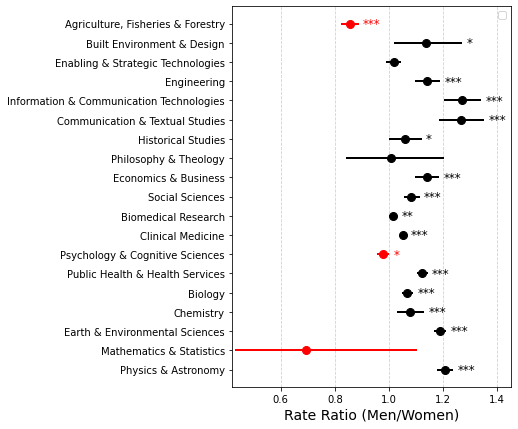

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame
df = a.copy()

# Set up the matplotlib figure
plt.figure(figsize=(5, 7))

# Add confidence interval lines with dots for odds ratio, color-coded by gender
for i, row in df.iterrows():
    color = "red" if row["gender"] == 0 else "black"
    plt.plot(row["odds_ratio"], i, 'o', markersize=8, color=color)
    plt.plot([row["left_ci"], row["right_ci"]], [i, i], color=color, linewidth=2)

# Annotate significance
for i, row in df.iterrows():
    plt.text(row["right_ci"] + 0.02, i, row["pval"], color="red" if row["gender"] == 0 else "black",
             verticalalignment="center", fontsize=12)

# Customize the plot
plt.yticks(range(len(df)), df["field"])
plt.xlabel("Rate Ratio (Men/Women)", fontsize=14)
#plt.title("Odds Ratio with Confidence Intervals", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.xlim(0.42,1.45)
plt.legend()
# Show the plot
plt.show()

### Regression analysis with men reference (men = 0, women = 1)

In [0]:
samp = unique_data.copy(deep = True)

gender = []
for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append(1)
    #gender.append("female")
    
  elif samp['cor_gender'][ind] == 'male' or samp['cor_gender'][ind] == 'm' or samp['cor_gender'][ind] == 'M':
    gender.append(0)
    #gender.append("male")
samp['gender'] = gender



coarse_team = []
for ind in samp.index:
  if samp['num_au'][ind] == 1:
      coarse_team.append('1')
  elif samp['num_au'][ind] == 2:
    coarse_team.append('2')
  elif samp['num_au'][ind] == 3:
    coarse_team.append('3')
  elif samp['num_au'][ind] >= 4 and samp['num_au'][ind] <= 5:
    coarse_team.append('4')
  elif samp['num_au'][ind] >= 6 and samp['num_au'][ind] <= 9:
    coarse_team.append('5')
  elif samp['num_au'][ind] > 9:
    coarse_team.append('6')

samp['team_size'] = coarse_team


q1, q2, q3 = 0.124, 0.25, 0.597

q = []
for ind in samp.index:
  if samp['SJR'][ind] <= q1:
    q.append(0)
  elif samp['SJR'][ind] > q1 and samp['SJR'][ind] <= q2:
    q.append(1)
  elif samp['SJR'][ind] > q2 and samp['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
samp['q'] = q

In [0]:
def domain_src2(i,nn):
  new = nn.copy(deep = True)
  cov = []
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #mm,ff = [],[]

  a = new[new['Field_English'] == i]

  f = a[a['gender'] == 1]
  m = a[a['gender'] == 0]
  print("male ",m['unique_counts'].mean()," female ",f['unique_counts'].mean())


  for ind in a.index:
    if a['year'][ind] == 2018 or a['year'][ind] == 2019:
      cov.append(0)
    else:
      cov.append(1)
  #a['covid'] = cov
  #a.loc[:,"covid"] = cov


  #a = a.drop(['srcid'], axis=1)
  a['srcid'] = a['srcid'].astype(str)
  a['cor_au1'] = a['cor_au1'].astype(str)

  return a


#tmp = domain_src2("Physics & Astronomy",samp.copy(deep = True)) #est=  0.1878671056, p val = 2.049421e-58 ***
tmp = domain_src2("Mathematics & Statistics",samp.copy(deep = True)) # gender -0.36672087, p val = 1.192890e-01
#tmp = domain_src2("Earth & Environmental Sciences",samp.copy(deep = True))# gender  est = 0.1727280303 , p val = 5.00786579e-101 *** 
#tmp = domain_src2("Chemistry",samp.copy(deep = True))  #gender  est = 0.075560029, p val = 5.45511892e-04 ***

#tmp = domain_src2("Biology",samp.copy(deep = True))  #gender   est = 0.066329239, p val = 5.489133227520739e-16 ***
#tmp = domain_src2("Public Health & Health Services",samp.copy(deep = True))  # gender est = 1.167129e-01, err = 0.006872478, p val = 1.10373607e-64 ***

#tmp = domain_src2("Psychology & Cognitive Sciences",samp.copy(deep = True))   #gender est -0.022366737, p value = 1.53335948e-02 *

#tmp = domain_src2("Clinical Medicine",samp.copy(deep = True)) #it has problem, so removed srcid, gendermale est = 0.05228468, p val = 1.026389e-64

#tmp = domain_src2("Biomedical Research",samp.copy(deep = True))  #gender est = 0.016064004 , p val = 4.64875817e-03 **
#tmp = domain_src2("Social Sciences",samp.copy(deep = True)) #gender est = 0.0799709439, p val = 6.41768693e-11 ***
#tmp = domain_src2("Economics & Business ",samp.copy(deep = True)) #gender est = 0.131894697, p value = 2.53909251e-13 *** 
#tmp = domain_src2("Visual & Performing Arts",samp) ##too small sample size #-0.6938

#tmp = domain_src2("Philosophy & Theology",samp.copy(deep = True)) #est = 0.006869409, p val = 9.390267e-01 
#tmp = domain_src2("Historical Studies",samp.copy(deep = True)) #est = 0.056608583 ,pval= 4.153950e-02 *
#tmp = domain_src2("Communication & Textual Studies",samp.copy(deep = True))  #est = 0.23582790 err = 0.03205681, p val =  1.887072e-13 ***
#tmp = domain_src2("Information & Communication Technologies",samp.copy(deep = True))  #gender est = 0.23921630, err = 0.0256, p val =  1.21978311e-20 ***

#tmp = domain_src2("Engineering",samp.copy(deep = True))  #est = 0.13303623, p val = 4.87299612e-12 ***
#tmp = domain_src2("Enabling & Strategic Technologies",samp.copy(deep = True)) #gender est = 0.017029,err= 0.0116, p val = 1.43182135e-01
#tmp = domain_src2("Built Environment & Design",samp.copy(deep = True)) #gender est = 0.12887945,err=0.0544, p val = 1.799847e-02 *
#tmp = domain_src2("Agriculture, Fisheries & Forestry",samp.copy(deep = True)) #gender est = -0.156602773 err = 0.0171747, p val = 7.63640556e-20 ***

#print(tmp.tail(10))


with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('covid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('covid'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('srcid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('srcid'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2'''

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("unique_counts ~ gender+year+subfield_article+team_size+srcid", #
                  data=tst_df,family=ro.r('poisson(link="log")')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')


print(base.summary(model).rx2("coefficients")) #run this for r output


coeffs = base.summary(model).rx2('coefficients')

male  2.7524752475247523  female  9.30232558139535
                                                         Estimate Std. Error
(Intercept)                                            0.35074828  0.7058505
gender1                                                0.36672087  0.2354148
year2019                                               0.24685468  0.2315149
year2020                                               0.17638787  0.2793288
year2021                                               0.04169855  0.3010198
year2022                                              -0.22644589  0.3577817
subfield_articlegeneral mathematics                   -0.27955781  0.3146274
subfield_articlenumerical & computational mathematics  0.51515090  0.4411219
subfield_articlestatistics & probability              -0.33138675  0.3139745
team_size2                                            -0.54145852  0.4027207
team_size3                                            -0.21381129  0.3819758
team_size4               

In [0]:
print(np.array(coeffs))

[[ 3.50748278e-01  7.05850504e-01  4.96915814e-01  6.19248419e-01]
 [ 3.66720871e-01  2.35414807e-01  1.55776468e+00  1.19289043e-01]
 [ 2.46854682e-01  2.31514884e-01  1.06625837e+00  2.86306864e-01]
 [ 1.76387871e-01  2.79328816e-01  6.31470372e-01  5.27733016e-01]
 [ 4.16985537e-02  3.01019751e-01  1.38524311e-01  8.89826057e-01]
 [-2.26445892e-01  3.57781733e-01 -6.32916305e-01  5.26788299e-01]
 [-2.79557807e-01  3.14627410e-01 -8.88536086e-01  3.74252454e-01]
 [ 5.15150899e-01  4.41121870e-01  1.16781990e+00  2.42879419e-01]
 [-3.31386748e-01  3.13974543e-01 -1.05545738e+00  2.91216193e-01]
 [-5.41458524e-01  4.02720690e-01 -1.34450138e+00  1.78786310e-01]
 [-2.13811288e-01  3.81975768e-01 -5.59750921e-01  5.75649344e-01]
 [ 4.65759357e-02  3.40057891e-01  1.36964725e-01  8.91058677e-01]
 [-3.72939075e-01  5.25869156e-01 -7.09186061e-01  4.78209023e-01]
 [-1.59636508e-01  1.16906592e+00 -1.36550476e-01  8.91386124e-01]
 [ 4.10325184e-01  7.06223461e-01  5.81013244e-01  5.61231528e

In [0]:
a = stats.confint_default(model)
print(a)

                                                            2.5 %    97.5 %
(Intercept)                                           -1.03269329 1.7341898
gender1                                               -0.09468367 0.8281254
year2019                                              -0.20690615 0.7006155
year2020                                              -0.37108655 0.7238623
year2021                                              -0.54828932 0.6316864
year2022                                              -0.92768520 0.4747934
subfield_articlegeneral mathematics                   -0.89621620 0.3371006
subfield_articlenumerical & computational mathematics -0.34943208 1.3797339
subfield_articlestatistics & probability              -0.94676554 0.2839920
team_size2                                            -1.33077657 0.2478595
team_size3                                            -0.96247004 0.5348475
team_size4                                            -0.61992528 0.7130772
team_size5  

### citation distribution of top 5% highly cited papers by male and female

<command-2186633871827221>:55: FutureWarning: The default value of regex will change from True to False in a future version.
  a['newdom'] = a['Domain_English'].str.replace(r'\s', '\n')
Out[13]: <matplotlib.legend.Legend at 0x7f9917ed5cd0>

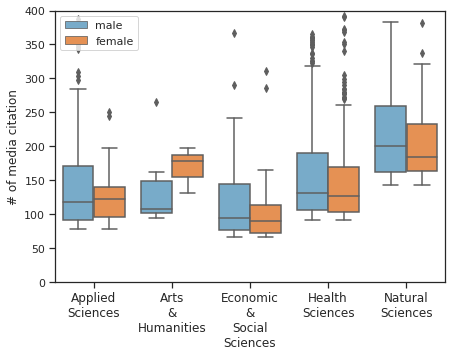

In [0]:
samp = unique_data.copy(deep = True)
gender = []
for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male")
samp['gender'] = gender

dtplt = pd.DataFrame()
for i in samp['Domain_English'].unique():
    s2 = samp[samp['Domain_English'] == i]
    top = s2['unique_counts'].quantile(0.99)

    top1 = s2[s2['unique_counts'] >= top]
    
    f = top1[top1['gender'] == "female"]

    m = top1[top1['gender'] == "male"]

    #dtplt = pd.concat([dtplt,top1])
    dtplt = pd.concat([dtplt,m])
    dtplt = pd.concat([dtplt,f])
    
    #print(i," female ",f_grp['unique_counts'].median()," male ",m_grp['unique_counts'].median())

'''import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette="Set1")
fig = plt.figure(figsize =(8, 6))

a = sns.color_palette(palette='tab20c')
a = a.as_hex()
c = {'male':a[1],'female':a[5]}

# Load the example tips dataset


# Draw a nested boxplot to show bills by day and time
sns.boxplot(y="unique_counts", x="Domain_English",
            hue="gender", palette=c,
            data=dtplt)
plt.xticks(fontsize = 8)
plt.ylim([0,300])'''

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette="Set1")
fig = plt.figure(figsize =(7, 5))
aa = sns.color_palette(palette='tab20c')
aa = aa.as_hex()
c = {'male':aa[1],'female':aa[5]}

a = dtplt.copy(deep = True)
a['newdom'] = a['Domain_English'].str.replace(r'\s', '\n')


ax = sns.boxplot(y="unique_counts", x="newdom",
            hue="gender", palette=c,
            data=a)

plt.xticks(fontsize = 12)
plt.ylim(0,400)
ax.set(xlabel=None)
plt.ylabel("# of media citation", fontsize = 12)
plt.legend(loc = "upper left")

### Regression without controlling source id


In [0]:
print(len(samp))
print(samp['Domain_English'].unique())

129428
['Applied Sciences' 'Arts & Humanities' 'Economic & Social Sciences'
 'Health Sciences' 'Natural Sciences']


In [0]:
def domain_src3(i,nn):
  new = nn.copy(deep = True)
  cov = []
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #mm,ff = [],[]

  a = new[new['Domain_English'] == i]

  f = a[a['gender'] == 1]
  m = a[a['gender'] == 0]
  print(len(a))
  print("male ",m['unique_counts'].mean()," female ",f['unique_counts'].mean())


  '''for ind in a.index:
    if a['year'][ind] == 2018 or a['year'][ind] == 2019:
      cov.append(0)
    else:
      cov.append(1)'''
  #a['covid'] = cov
  #a.loc[:,"covid"] = cov


  #a = a.drop(['srcid'], axis=1)
  a['srcid'] = a['srcid'].astype(str)
  a['cor_au1'] = a['cor_au1'].astype(str)

  return a


#tmp = domain_src3("Applied Sciences",samp.copy(deep = True)) #est= -0.07398184 err = 0.007180, p ***
#tmp = domain_src3("Arts & Humanities",samp.copy(deep = True)) #est=  -0.240502417, err = 0.01654856, p ***
#tmp = domain_src3("Economic & Social Sciences",samp.copy(deep = True)) # est = -0.1670085475, err = 0.008657338, p val = ***
#tmp = domain_src3("Health Sciences",samp.copy(deep = True)) # est = -0.079640376, err = 0.002375149, p val = ***
tmp = domain_src3("Natural Sciences",samp.copy(deep = True)) # est = -0.17641007, err = 0.004829790, p val = ***



with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('srcid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('srcid'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2'''

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("unique_counts ~ gender+year+subfield_article+team_size+q", #
                  data=tst_df,family=ro.r('poisson(link="log")')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')


print(base.summary(model).rx2("coefficients")) #run this for r output


coeffs = base.summary(model).rx2('coefficients')

17674
male  12.89965342145563  female  11.684070628441239
<command-527924446592755>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['srcid'] = a['srcid'].astype(str)
<command-527924446592755>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['cor_au1'] = a['cor_au1'].astype(str)
                                                         Estimate  Std. Error
(Intercept)                                            2.09812720 0.208068411
gender1                                               -0.17641007 0.00

In [0]:
import numpy as np
def cohend(d,outcome, val, domain):
    data = d[d['Domain_English'] == domain]
    print("len of data ",len(data))
    grp1 = data[data[outcome] == 1]
    grp0 = data[data[outcome] == 0]

    n0,n1 = len(grp0),len(grp1)
    m0, m1 = grp0[val].mean(), grp1[val].mean()

    s0,s1 = grp0[val].std(), grp1[val].std()

    print("n0 ",n0," n1 ",n1, " m0 ",m0," m1 ",m1, " s0 ",s0," s1 ",s1)

    spooled1 = np.sqrt(((s0*s0)+(s1*s1))/2)
    print("cohen d ", (m1 - m0)/spooled1)

    spooled2 = (((n0 - 1) * s0 * s0) + ((n1 - 1) * s1 * s1))/(n0 + n1 - 2)
    spooled2 = np.sqrt(spooled2)
    print("cohen d ", (m1 - m0)/spooled2)

#cohend(samp.copy(deep = True), 'gender','unique_counts','Applied Sciences') #-0.04

#cohend(samp.copy(deep = True), 'gender','unique_counts','Arts & Humanities') #-0.16

#cohend(samp.copy(deep = True), 'gender','unique_counts','Economic & Social Sciences') #-0.07

#cohend(samp.copy(deep = True), 'gender','unique_counts','Natural Sciences') #-0.04

cohend(samp.copy(deep = True), 'gender','unique_counts','Health Sciences') #-0.0167

len of data  91016
n0  54322  n1  36694  m0  8.863554361032362  m1  8.515533874747915  s0  21.233317028825507  s1  20.275823114295097
cohen d  -0.016763919128152824
cohen d  -0.016689559950045126


### Draft

In [0]:
samp = unique_data.copy(deep = True)
gender = []
for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male")
samp['gender'] = gender
print("total number of papers ",len(samp))
#print("total unique media ",a['media'].nunique())
print("total media citation ",samp['unique_counts'].sum())

print("len of female cor au ",len(samp[samp['gender'] == "female"]), " len of male cor au ",len(samp[samp['gender'] == "male"]))


for i in samp['Domain_English'].unique():
    grp = samp[samp['Domain_English'] == i]

    print(i," total doi",len(grp)," ",len(grp)/len(samp)," total citation ",grp['unique_counts'].sum()," ",grp['unique_counts'].sum()/samp['unique_counts'].sum()," female ",len(grp[grp['gender'] == "female"])," ",len(grp[grp['gender'] == "female"])/len(grp)," male ", len(grp[grp['gender'] == "male"])," ",len(grp[grp['gender'] == "male"])/len(grp))

total number of papers  129428
total media citation  1195149
len of female cor au  49331  len of male cor au  80097
Applied Sciences  total doi 11418   0.08821893253391848  total citation  103950   0.08697660291729316  female  3284   0.28761604484147835  male  8134   0.7123839551585216
Arts & Humanities  total doi 1596   0.012331180270111567  total citation  16301   0.013639303551272686  female  712   0.44611528822055135  male  884   0.5538847117794486
Economic & Social Sciences  total doi 7724   0.05967796767314646  total citation  59357   0.049664937175197404  female  3374   0.43682030036250646  male  4350   0.5631796996374935
Health Sciences  total doi 91016   0.7032172327471644  total citation  793955   0.6643146586743578  female  36694   0.4031598839764437  male  54322   0.5968401160235562
Natural Sciences  total doi 17674   0.13655468677565905  total citation  221586   0.185404497681879  female  5267   0.2980083738825393  male  12407   0.7019916261174607


In [0]:
print(unique_data.head(2))

      Domain_English                      Field_English  \
0   Applied Sciences  Agriculture, Fisheries & Forestry   
18  Applied Sciences  Agriculture, Fisheries & Forestry   

          SubField_English        srcid openaccess_status  \
0   agronomy & agriculture  21100941001               YES   
18  agronomy & agriculture        21121                NO   

                          doi  news_cnt  year      issn  num_au  ...  \
0   10.3389/fsufs.2020.577723        21  2020  2571581X       5  ...   
18    10.1073/pnas.1818400116         7  2019  00278424      29  ...   

   Au1_gender   country_name    SJR        subfield_article  \
0        male  United States  0.729  agronomy & agriculture   
18       male  United States  5.165  agronomy & agriculture   

                    preferred_name org_type      cor_au1       media  is_top  \
0   University of Colorado Boulder     univ  56002786300  red/acción     0.0   
18  University of Colorado Boulder     univ  35179276400         apa   

In [0]:
a[a['doi'] == "10.3389/fsufs.2020.577723"]

,Domain_English,Field_English,SubField_English,srcid,openaccess_status,doi,news_cnt,year,issn,num_au,...,TopicId,Au1_gender,country_name,SJR,subfield_article,preferred_name,org_type,cor_au1,media,is_top
0,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,21100941001,YES,10.3389/fsufs.2020.577723,21,2020,2571581X,5,...,3195,male,United States,0.729,agronomy & agriculture,University of Colorado Boulder,univ,56002786300,red/acción,0.0
1,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,21100941001,YES,10.3389/fsufs.2020.577723,21,2020,2571581X,5,...,3195,male,United States,0.729,agronomy & agriculture,University of Colorado Boulder,univ,56002786300,yahoo!news,1.0
2,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,21100941001,YES,10.3389/fsufs.2020.577723,21,2020,2571581X,5,...,3195,male,United States,0.729,agronomy & agriculture,University of Colorado Boulder,univ,56002786300,newscabal,0.0
3,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,21100941001,YES,10.3389/fsufs.2020.577723,21,2020,2571581X,5,...,3195,male,United States,0.729,agronomy & agriculture,University of Colorado Boulder,univ,56002786300,msn,1.0
4,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,21100941001,YES,10.3389/fsufs.2020.577723,21,2020,2571581X,5,...,3195,male,United States,0.729,agronomy & agriculture,University of Colorado Boulder,univ,56002786300,theguardian,1.0
5,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,21100941001,YES,10.3389/fsufs.2020.577723,21,2020,2571581X,5,...,3195,male,United States,0.729,agronomy & agriculture,University of Colorado Boulder,univ,56002786300,newsbreak,0.0
6,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,21100941001,YES,10.3389/fsufs.2020.577723,21,2020,2571581X,5,...,3195,male,United States,0.729,agronomy & agriculture,University of Colorado Boulder,univ,56002786300,nationalobserver,0.0
7,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,21100941001,YES,10.3389/fsufs.2020.577723,21,2020,2571581X,5,...,3195,male,United States,0.729,agronomy & agriculture,University of Colorado Boulder,univ,56002786300,expoknews,0.0
8,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,21100941001,YES,10.3389/fsufs.2020.577723,21,2020,2571581X,5,...,3195,male,United States,0.729,agronomy & agriculture,University of Colorado Boulder,univ,56002786300,ecobusiness,0.0
9,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,21100941001,YES,10.3389/fsufs.2020.577723,21,2020,2571581X,5,...,3195,male,United States,0.729,agronomy & agriculture,University of Colorado Boulder,univ,56002786300,newscolony,0.0


In [0]:
f.groupby('cor_au1')['unique_counts'].sum().reset_index()

abc = pd.DataFrame()
abc['name'] = ['a','b','a','c','d']
abc['age'] = [1,2,3,4,5]
abc['dd'] = [0,9,0,8,1]
print(abc)
abc = abc.groupby('name')['age'].sum().reset_index()
print(abc)

  name  age  dd
0    a    1   0
1    b    2   9
2    a    3   0
3    c    4   8
4    d    5   1
  name  age
0    a    4
1    b    2
2    c    4
3    d    5


In [0]:
#https://www.geeksforgeeks.org/specify-reference-factor-level-in-linear-regression-in-r/

In [0]:
import pandas as pd 

a = pd.DataFrame()
a['id'] = [1,2,3,4,5,1,2]
a['name'] = ['a','b','c','d','e','b','a']

b = pd.DataFrame()
b['name'] = ['a','b','c','d','x','f','g']
b['gg'] = ['ao','bo','co','do','eo','fo','go']

res = a.merge(b, on = "name", how = "left")
print(res)


   id name   gg
0   1    a   ao
1   2    b   bo
2   3    c   co
3   4    d   do
4   5    e  NaN
5   1    b   bo
6   2    a   ao


In [0]:
print(samp['SubField_English'].unique())

['agronomy & agriculture' 'dairy & animal science' 'fisheries'
 'food science' 'forestry' 'horticulture' 'veterinary sciences'
 'building & construction' 'design practice & management'
 'urban & regional planning' 'bioinformatics' 'biotechnology' 'energy'
 'materials' 'nanoscience & nanotechnology' 'optoelectronics & photonics'
 'strategic, defence & security studies' 'aerospace & aeronautics'
 'biomedical engineering' 'chemical engineering' 'civil engineering'
 'electrical & electronic engineering' 'environmental engineering'
 'geological & geomatics engineering'
 'industrial engineering & automation'
 'mechanical engineering & transports' 'mining & metallurgy'
 'operations research' 'artificial intelligence & image processing'
 'computation theory & mathematics' 'computer hardware & architecture'
 'distributed computing' 'information systems' 'medical informatics'
 'networking & telecommunications' 'software engineering'
 'communication & media studies' 'languages & linguistics'
 'li

In [0]:
df_wos = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/wos_gender_firstname.csv")
display(df_wos.limit(10))

country,givenname,gender
Afghanistan,Abdul,M
Afghanistan,Abdul Ali,M
Afghanistan,Abdul Ghani,M
Afghanistan,Abdul Hakim,M
Afghanistan,Abdul Halim,M
Afghanistan,Abdul Hamid,M
Afghanistan,Abdul Khalil,M
Afghanistan,Abdul M.,M
Afghanistan,Abdul Majeed,M
Afghanistan,Abdul Naser,M


In [0]:
#https://statisticsbyjim.com/basics/effect-sizes-statistics/
#https://www.statisticshowto.com/pooled-standard-deviation/
#https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/cohens-d/
#https://lbecker.uccs.edu/#means%20and%20standard%20deviations